In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap
from xgboost import XGBRegressor
import time
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore') 

C:\Users\liqiansd\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def del_constant(df_train):
    column_names = df_train.columns.tolist()
    column_names.remove('Repeat_Unit')
    column_names.remove('Tg')
    All_des = df_train[column_names].values
    selector = VarianceThreshold() 
    selector.fit_transform(All_des) 
    sel = selector.get_support(indices=True) 
    sel_name = []
    for i in range(len(sel)):
        m = sel[i]
        sel_name.append(column_names[m]) 
    cols = ['Repeat_Unit'] + sel_name + ['Tg']
    df = df_train[cols] 
    return df

In [3]:
def del_Colinear(train_df):
    
    threshold = 0.95
    
    df = train_df.drop(columns=['Repeat_Unit'])
    r_pearson = df.corr(method='pearson') 
    del_name = []
    for i in range(r_pearson.shape[0]-1): 
        if r_pearson.columns[i] in del_name:
            continue
        else:
            for j in range(i+1, r_pearson.shape[0]-1):
                if abs(r_pearson.iat[i, j]) > threshold: 
                    r_tg_i = r_pearson.loc[r_pearson.columns[i], 'Tg']
                    r_tg_j = r_pearson.loc[r_pearson.columns[j], 'Tg'] 
                    if abs(r_tg_i) >= abs(r_tg_j):
                        if r_pearson.columns[j] not in del_name:
                            del_name.append(r_pearson.columns[j])
                    else:
                        if r_pearson.columns[i] not in del_name:
                            del_name.append(r_pearson.columns[i])
                            break
                else:
                    continue

    newdf = train_df.drop(columns=del_name)
    return newdf

In [4]:
df0 = pd.read_csv('./polymer_content_molecule_descriptors_final.csv')
df_t1 = del_constant(df0)
df = del_Colinear(df_t1)
df = df[:40]

In [5]:
# %run kNNMTD3.0.py
%run utils.py
%run kNNMTD2.0.py


In [47]:
real = df.drop(columns=['Repeat_Unit'])
generator = kNNMTD(n_obs=200, k=5,sigma_factor=0.25,random_state=2042)
synthetic = generator.fit(real, class_col='Tg')
synthetic
pcd = PCD(real,synthetic)

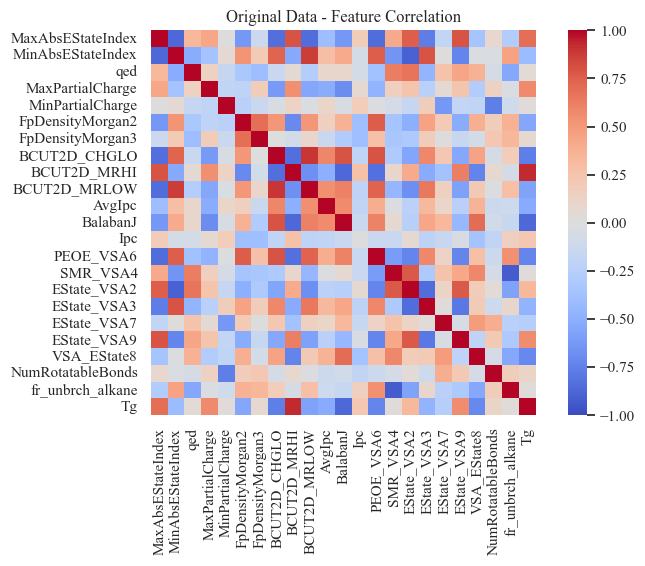

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 计算相关系数矩阵
real_corr = real.corr()
synthetic_corr = synthetic.corr()

# 绘图
plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
# plt.subplot(1, 2, 1)
sns.heatmap(real_corr, cmap='coolwarm', vmin=-1, vmax=1, square=True, annot=False)
plt.title("Original Data - Feature Correlation")

# plt.subplot(1, 2, 2)
# sns.heatmap(synthetic_corr, cmap='coolwarm', vmin=-1, vmax=1, square=True, annot=False)
# plt.title("Generated Data - Feature Correlation")

plt.tight_layout()
plt.savefig('Feature Correlation-content.svg', format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
plt.show()


In [9]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
from numpy.linalg import norm

# 1. Mean and Std Similarity
def mean_std_diff(original, generated):
    mean_diff = np.abs(np.mean(original, axis=0) - np.mean(generated, axis=0)).mean()
    std_diff = np.abs(np.std(original, axis=0) - np.std(generated, axis=0)).mean()
    return mean_diff, std_diff

# 2. Jensen-Shannon Divergence (per feature averaged)
def js_divergence(original, generated, bins=30):
    js_total = 0
    for i in range(original.shape[1]):
        o_hist, _ = np.histogram(original[:, i], bins=bins, density=True)
        g_hist, _ = np.histogram(generated[:, i], bins=bins, density=True)

        # Add small value to avoid 0 in log
        o_hist += 1e-8
        g_hist += 1e-8
        js_total += jensenshannon(o_hist, g_hist) ** 2
    return js_total / original.shape[1]

# 3. Fréchet Distance (FD) between mean and covariances
def frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = np.sqrt(sigma1 @ sigma2 + 1e-6 * np.eye(sigma1.shape[0]))  # stability
    return np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_fd(original, generated):
    mu1 = np.mean(original, axis=0)
    sigma1 = np.cov(original, rowvar=False)
    mu2 = np.mean(generated, axis=0)
    sigma2 = np.cov(generated, rowvar=False)
    return frechet_distance(mu1, sigma1, mu2, sigma2)

# 4. Pearson correlation matrix difference
def correlation_difference(original, generated):
    corr1 = np.corrcoef(original, rowvar=False)
    corr2 = np.corrcoef(generated, rowvar=False)
    return np.mean(np.abs(corr1 - corr2))



In [15]:

# real=real.to_numpy()
# synthetic=synthetic.to_numpy()
scaler = StandardScaler()
combined = np.vstack([real, synthetic])
scaled = scaler.fit_transform(combined)

# 拆分回来
real_scaled = scaled[:len(real)]
synthetic_scaled = scaled[len(real):]
# 运行计算
mean_diff, std_diff = mean_std_diff(real_scaled, synthetic_scaled)
js_score = js_divergence(real_scaled, synthetic_scaled)
fd_score = compute_fd(real_scaled, synthetic_scaled)
corr_diff = correlation_difference(real_scaled, synthetic_scaled)

# 打印结果
print(f"Mean Difference: {mean_diff:.4f}")
print(f"Std Difference: {std_diff:.4f}")
print(f"Jensen-Shannon Divergence: {js_score:.4f}")
print(f"Fréchet Distance: {fd_score:.4f}")
print(f"Correlation Matrix Difference: {corr_diff:.4f}")


Mean Difference: 0.0761
Std Difference: 0.2614
Jensen-Shannon Divergence: 0.2851
Fréchet Distance: nan
Correlation Matrix Difference: 0.1974


In [16]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma)
    yy = rbf_kernel(y, y, gamma)
    xy = rbf_kernel(x, y, gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

mmd_score = compute_mmd(real_scaled, synthetic_scaled)
print(f"MMD score: {mmd_score:.4f}")

MMD score: 0.0310


In [17]:
from scipy.stats import ks_2samp
import numpy as np
import pandas as pd

def ks_test_all_features(original, generated):
    p_values = []
    for i in range(original.shape[1]):
        stat, p = ks_2samp(original[:, i], generated[:, i])
        p_values.append(p)
    return p_values

# 假设 original_scaled 和 generated_scaled 是已标准化后的 numpy 数组
p_values = ks_test_all_features(real_scaled, synthetic_scaled)

# 显示每个特征的p值
for i, p in enumerate(p_values):
    print(f"Feature {i+1}: p-value = {p:.4f}")


Feature 1: p-value = 0.8329
Feature 2: p-value = 0.5030
Feature 3: p-value = 0.0000
Feature 4: p-value = 0.0829
Feature 5: p-value = 0.0009
Feature 6: p-value = 0.9596
Feature 7: p-value = 0.6950
Feature 8: p-value = 0.9596
Feature 9: p-value = 0.9981
Feature 10: p-value = 0.4582
Feature 11: p-value = 0.9074
Feature 12: p-value = 0.9366
Feature 13: p-value = 1.0000
Feature 14: p-value = 0.9366
Feature 15: p-value = 0.0829
Feature 16: p-value = 0.1882
Feature 17: p-value = 0.9596
Feature 18: p-value = 0.0011
Feature 19: p-value = 0.6462
Feature 20: p-value = 0.9879
Feature 21: p-value = 0.0714
Feature 22: p-value = 0.4582
Feature 23: p-value = 1.0000


In [50]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind, entropy
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def kde_overlap(x, y, bandwidth=0.2):
    """KDE overlap area"""
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x[:, None])
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y[:, None])
    
    xs = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), 1000)
    log_dens1 = kde1.score_samples(xs[:, None])
    log_dens2 = kde2.score_samples(xs[:, None])
    dens1 = np.exp(log_dens1)
    dens2 = np.exp(log_dens2)
    return np.trapz(np.minimum(dens1, dens2), xs)  # Overlap area [0,1]

def kl_divergence(p, q, bins=8):
    """KL散度（基于直方图）"""
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)
    # 加上1e-10防止除零或log0
    return entropy(p_hist + 1e-10, q_hist + 1e-10)

def ml_model_test(X_real, X_fake):
    """使用分类模型检验可区分性"""
    X = np.vstack([X_real, X_fake])
    y = np.array([0] * len(X_real) + [1] * len(X_fake))
    clf = RandomForestClassifier(n_estimators=100)
    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    return scores.mean()

# 执行全部方法
def compare_distributions(df_real, df_fake, scale=True):
    if scale:
        scaler = StandardScaler()
        df_real = pd.DataFrame(scaler.fit_transform(df_real), columns=df_real.columns)
        df_fake = pd.DataFrame(scaler.transform(df_fake), columns=df_fake.columns)

    results = []
    for col in df_real.columns:
        real_col = df_real[col].dropna().values
        fake_col = df_fake[col].dropna().values

        ks_p = ks_2samp(real_col, fake_col).pvalue
        t_p = ttest_ind(real_col, fake_col, equal_var=False).pvalue
        overlap = kde_overlap(real_col, fake_col)
        kl = kl_divergence(real_col, fake_col)

        results.append({
            "Feature": col,
            "KS p-value": ks_p,
            "T-test p-value": t_p,
            "Overlap Rate": overlap,
            "KL Divergence": kl
        })

    # 模型整体检验
    model_score = ml_model_test(df_real.values, df_fake.values)

    df_result = pd.DataFrame(results)
    print(f"\nML模型检测分布区分性（AUC）: {model_score:.4f}")
    return df_result


In [42]:
import pandas as pd

real0=df.drop(columns=['Repeat_Unit'])
feature_names = real0.columns.tolist()
df_real = pd.DataFrame(real_scaled, columns=feature_names)
df_fake = pd.DataFrame(synthetic_scaled, columns=feature_names)

result = compare_distributions(df_real, df_fake)

# 显示结果表格
print(result)


ML模型检测分布区分性（AUC）: 0.8091
              Feature    KS p-value  T-test p-value  Overlap Rate  \
0   MaxAbsEStateIndex  8.329025e-01    9.585849e-01      0.839289   
1   MinAbsEStateIndex  5.029845e-01    5.871011e-01      0.832232   
2                 qed  5.845644e-12    2.423533e-09      0.246124   
3    MaxPartialCharge  8.289010e-02    9.731126e-01      0.834324   
4    MinPartialCharge  8.640121e-04    3.365368e-01      0.367637   
5    FpDensityMorgan2  9.596116e-01    6.558474e-01      0.871716   
6    FpDensityMorgan3  6.950462e-01    9.752501e-01      0.820073   
7        BCUT2D_CHGLO  9.596116e-01    7.869647e-01      0.886102   
8         BCUT2D_MRHI  9.980652e-01    9.584029e-01      0.941669   
9        BCUT2D_MRLOW  4.582381e-01    5.165498e-01      0.817856   
10             AvgIpc  9.073700e-01    9.846728e-01      0.843184   
11           BalabanJ  9.365500e-01    8.869992e-01      0.875857   
12                Ipc  1.000000e+00    7.817538e-01      0.950019   
13      

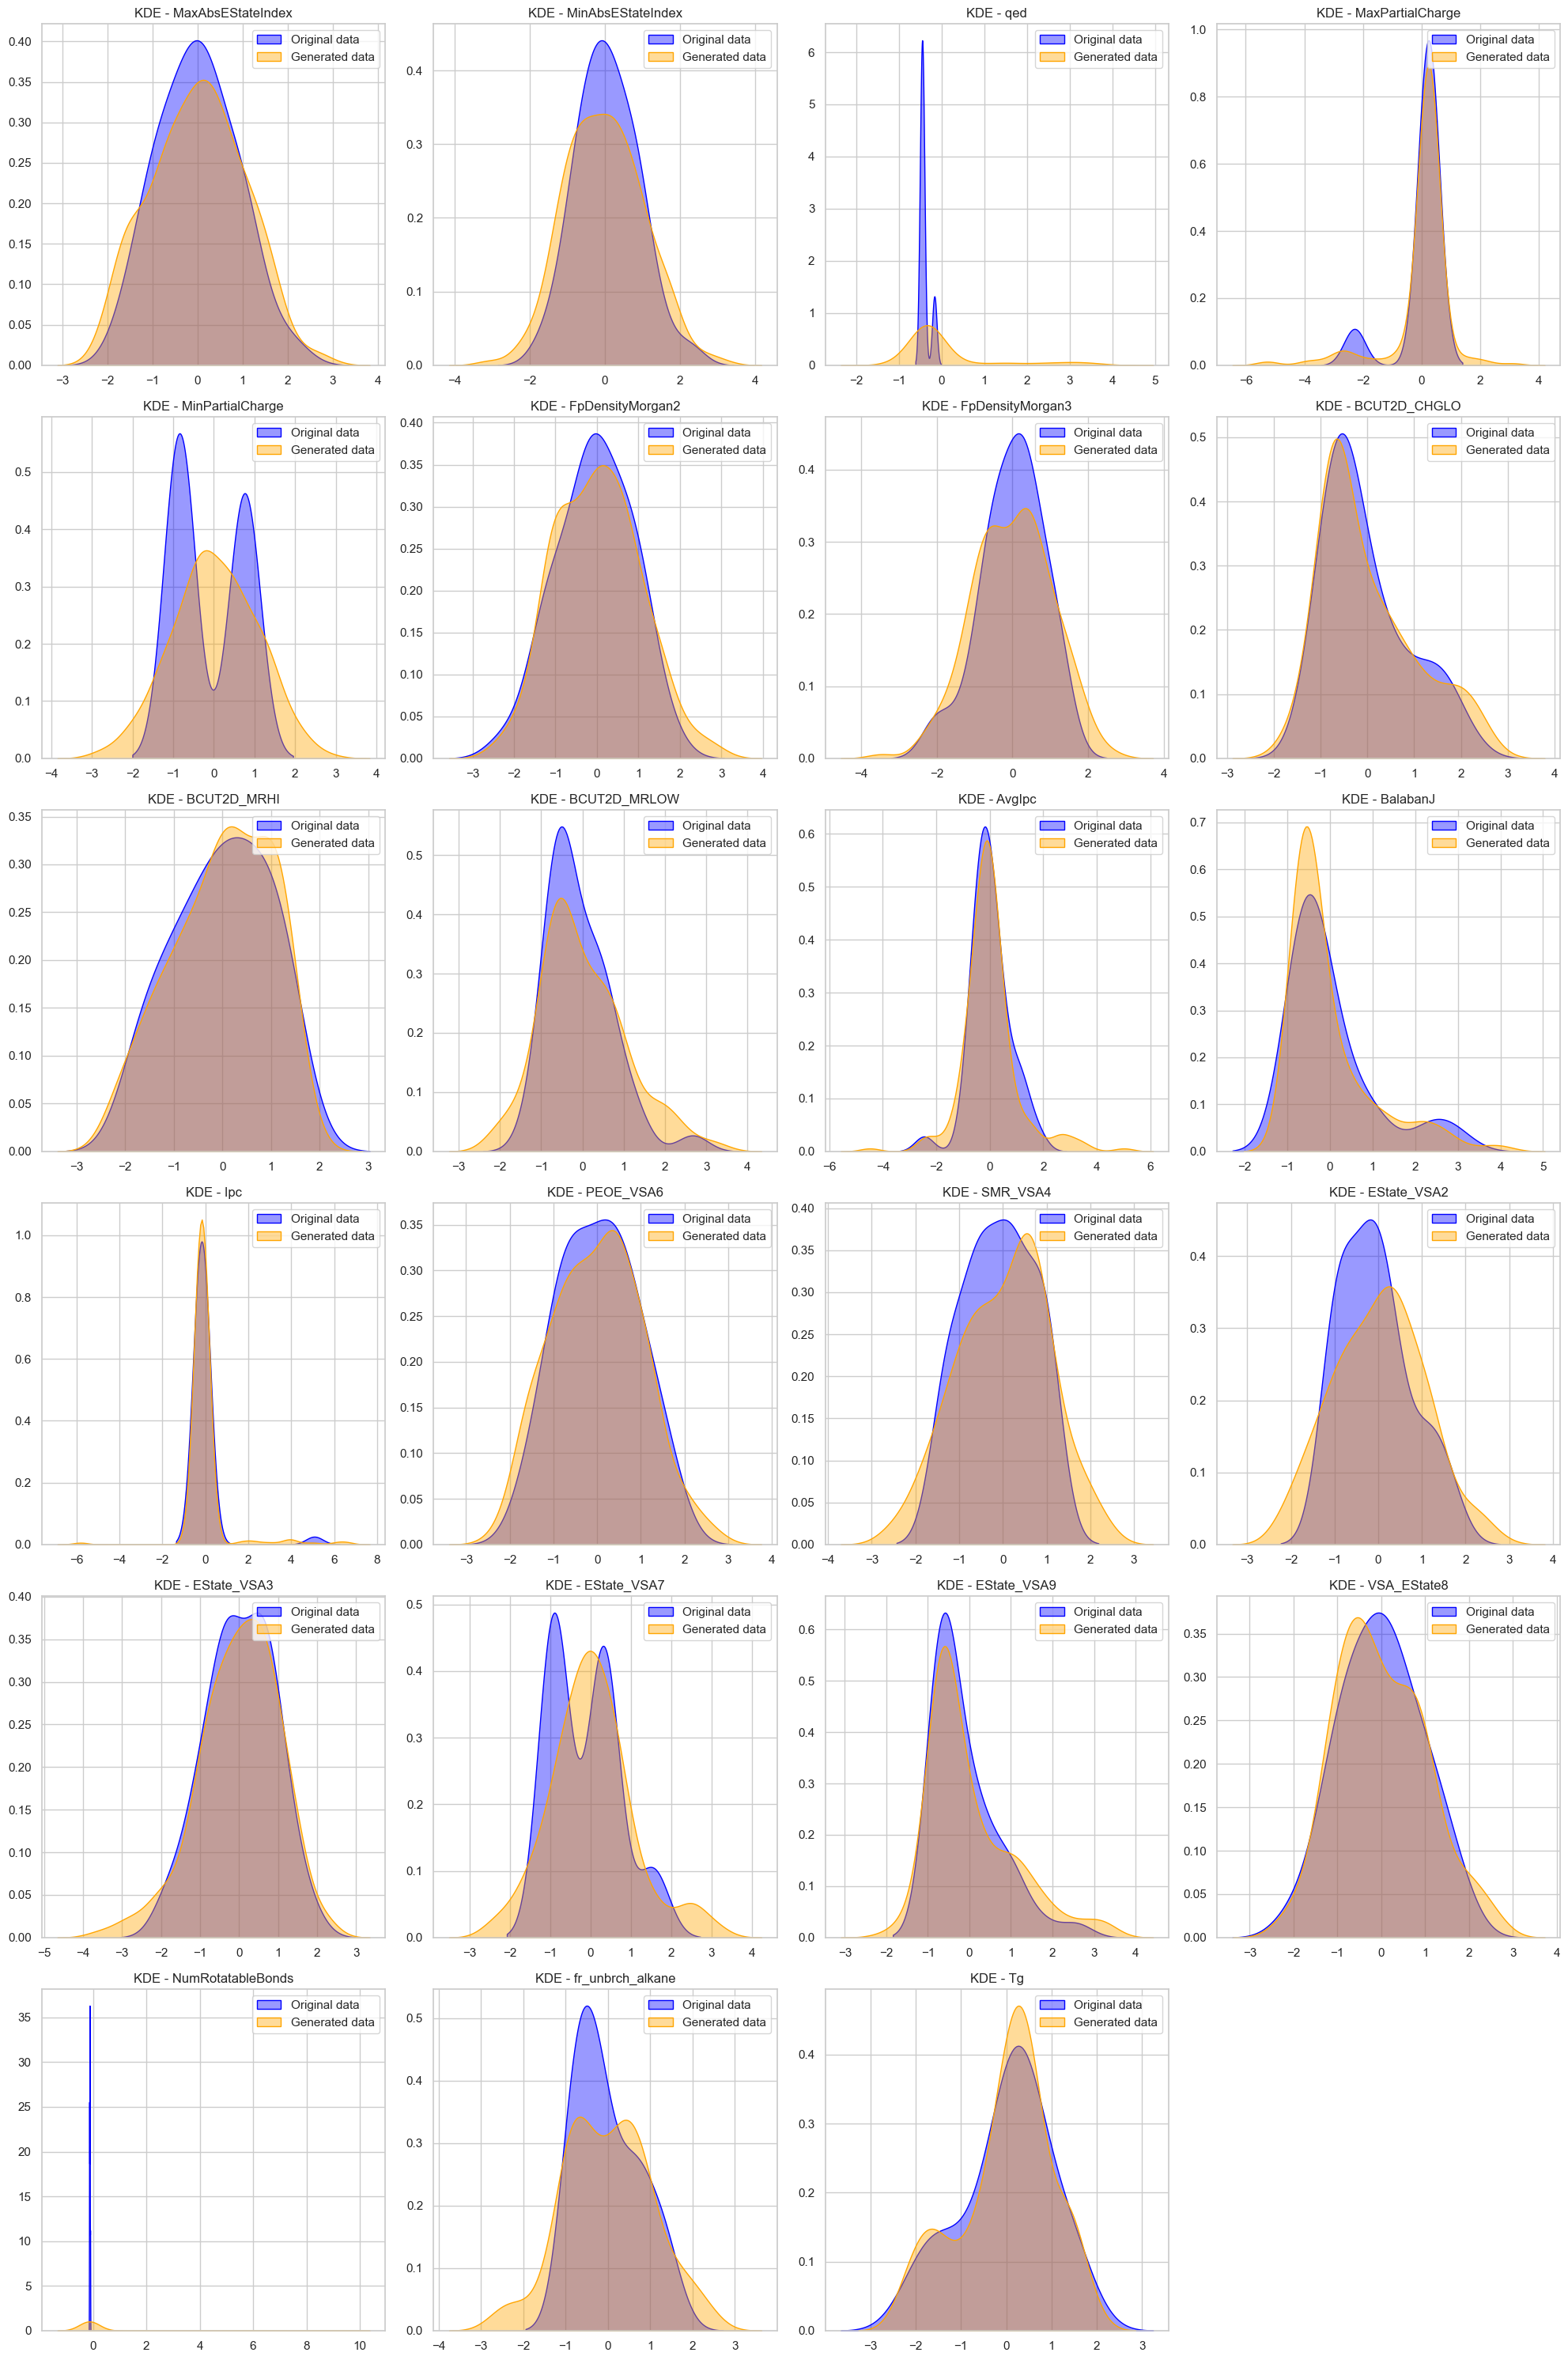

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置画图风格
sns.set(style='whitegrid')
plt.figure(figsize=(20, 30))  # 调整画布尺寸

# 遍历所有 20 个特征
for i, feature in enumerate(feature_names):
    plt.subplot(6, 4, i + 1)  # 5 行 4 列，共 20 子图
    sns.kdeplot(df_real[feature], label='Original data', color='blue', fill=True, alpha=0.4)
    sns.kdeplot(df_fake[feature], label='Generated data', color='orange', fill=True, alpha=0.4)
    plt.title(f'KDE - {feature}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc='upper right')

plt.tight_layout()
# plt.suptitle('KDE Comparison for Each Feature', fontsize=16, y=1.02)
plt.savefig('generated vs original kde.svg', format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
plt.show()


In [189]:
# 固定外部种子（确保数据集划分一致）
np.random.seed(42)

# 参数设置
n_experiments = 10  # 重复实验次数
k = 5  # 假设最佳k值为5
n_obs = 200

# 存储每次实验的结果
all_results = []

# 重复实验
for experiment_id in range(n_experiments):
    print(f"\n实验 {experiment_id + 1}/{n_experiments}")
    
    # 每次实验使用不同的内部种子
    internal_seed = 42 + experiment_id  # 基于实验ID生成不同的种子
    
    # 数据准备（假设df已加载）
    real = df.drop(columns=['Repeat_Unit'])
    
    # 初始化模型，使用不同的随机种子
    generator = kNNMTD(n_obs=n_obs, k=k, random_state=internal_seed, sigma_factor=0.25)
    
    # 生成合成数据
    synthetic = generator.fit(train=real, class_col='Tg')
    
    # 评估性能
    pcd = PCD(real, synthetic)
    
    # 存储结果
    all_results.append({
        'experiment_id': experiment_id + 1,
        'random_state': internal_seed,
        'PCD': pcd
    })

# 转换为DataFrame并分析结果
results_df = pd.DataFrame(all_results)

# 计算统计量
mean_pcd = results_df['PCD'].mean()
std_pcd = results_df['PCD'].std()
min_pcd = results_df['PCD'].min()
max_pcd = results_df['PCD'].max()

print("\n稳定性评估结果:")
print(f"PCD均值: {mean_pcd:.4f} ± {std_pcd:.4f}")
print(f"PCD最小值: {min_pcd:.4f}")
print(f"PCD最大值: {max_pcd:.4f}")
print(f"波动范围: {max_pcd - min_pcd:.4f}")




实验 1/10

实验 2/10

实验 3/10

实验 4/10

实验 5/10

实验 6/10

实验 7/10

实验 8/10

实验 9/10

实验 10/10

稳定性评估结果:
PCD均值: 9.2846 ± 0.1135
PCD最小值: 9.1097
PCD最大值: 9.5368
波动范围: 0.4271


In [190]:
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 参数设置
k_list = [3, 4, 5, 6, 7, 8, 9]  # k值列表
n_experiments = 10  # 重复实验次数
n_obs = 200

# 存储所有实验结果
all_results = []

# 外层循环：重复实验
for exp_id in range(n_experiments):
    print(f"\n实验 {exp_id+1}/{n_experiments}")
    
    # 内层循环：评估不同k值
    for k in k_list:
        print(f"  评估 k={k}")
        
        try:
            # 设置基于实验ID和k的随机种子
            random_seed = 42 + exp_id * 100 + k
            
            real = df.drop(columns=['Repeat_Unit'])
            
            # 初始化模型，使用不同的随机种子
            generator = kNNMTD(n_obs=n_obs, k=k, random_state=random_seed, sigma_factor=0.25)
            
            # 生成合成数据
            synthetic = generator.fit(train=real, class_col='Tg')
            
            # 计算PCD评分
            pcd = PCD(real, synthetic)
            
            # 存储本次实验结果
            all_results.append({
                'k': k,
                'experiment_id': exp_id,
                'random_state': random_seed,
                'PCD': pcd
            })
            
        except Exception as e:
            print(f"  k={k} 出错: {e}")
            all_results.append({
                'k': k,
                'experiment_id': exp_id,
                'PCD': np.nan
            })

# 转换为DataFrame
results_df = pd.DataFrame(all_results)

# 计算每个k值的平均PCD和标准差
summary_df = results_df.groupby('k')['PCD'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
summary_df.columns = ['k', 'mean_PCD', 'std_PCD', 'min_PCD', 'max_PCD', 'valid_experiments']

# 找出平均PCD最低的k值
best_k = summary_df.loc[summary_df['mean_PCD'].idxmin()]
print(f"\n最佳k值（基于{ n_experiments }次实验的平均PCD）: k={best_k['k']}")
print(f"平均PCD: {best_k['mean_PCD']:.4f} ± {best_k['std_PCD']:.4f}")
print(f"PCD范围: {best_k['min_PCD']:.4f} ~ {best_k['max_PCD']:.4f}")




实验 1/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 2/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 3/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 4/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 5/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 6/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 7/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 8/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 9/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

实验 10/10
  评估 k=3
  评估 k=4
  评估 k=5
  评估 k=6
  评估 k=7
  评估 k=8
  评估 k=9

最佳k值（基于10次实验的平均PCD）: k=8.0
平均PCD: 9.3003 ± 0.0894
PCD范围: 9.1789 ~ 9.4605


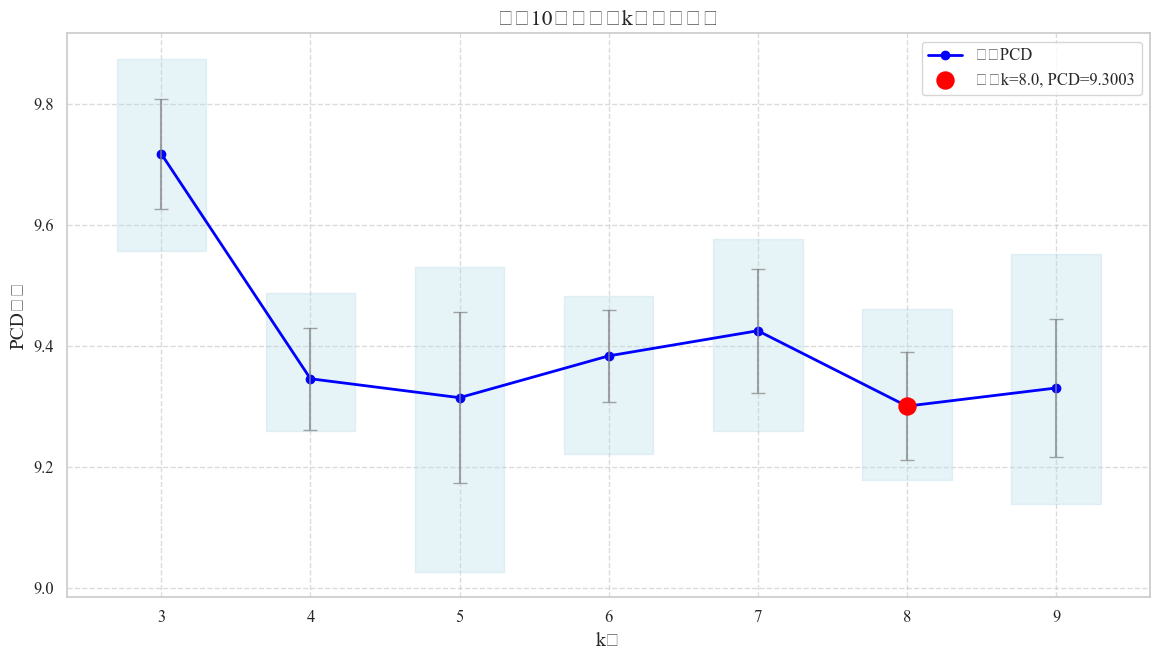

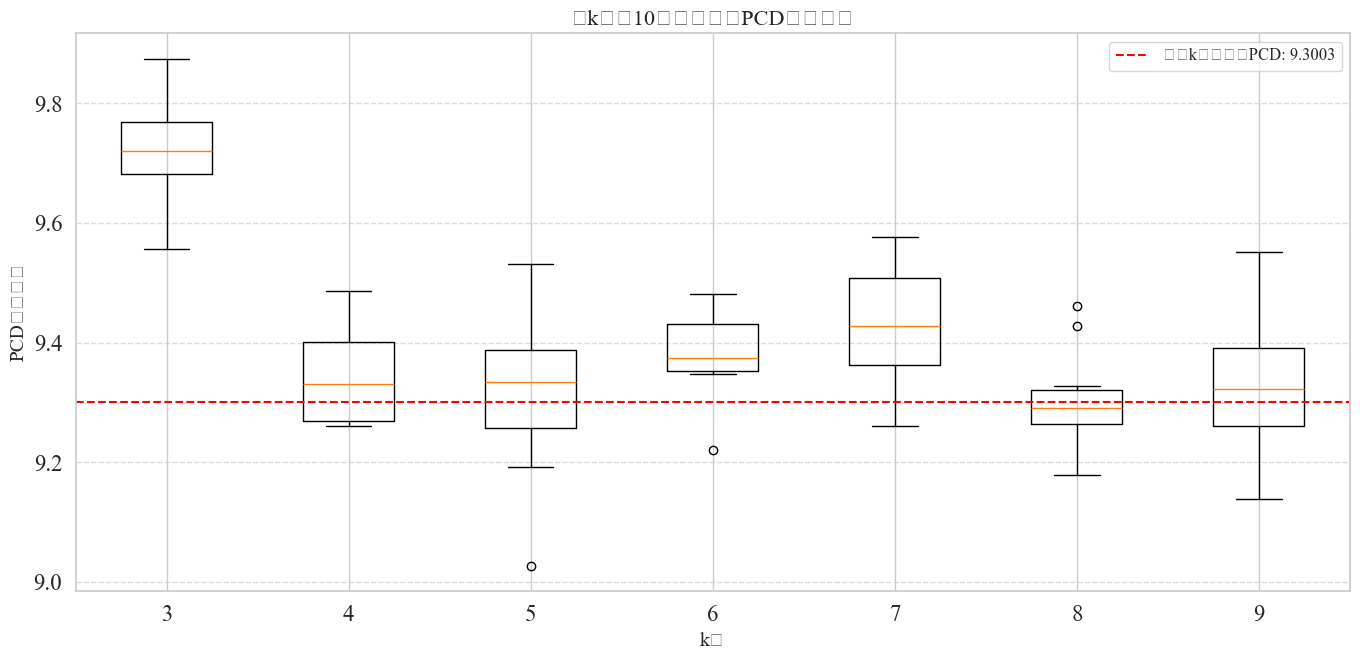

In [191]:
# 绘制每个k值的平均PCD和波动范围
plt.figure(figsize=(12, 7))

# 绘制平均值曲线
plt.plot(summary_df['k'], summary_df['mean_PCD'], 'o-', color='blue', linewidth=2, label='平均PCD')

# 标记最佳k值
plt.scatter([best_k['k']], [best_k['mean_PCD']], color='red', s=150, zorder=5, 
            label=f'最佳k={best_k["k"]}, PCD={best_k["mean_PCD"]:.4f}')

# 添加误差线（标准差）
plt.errorbar(summary_df['k'], summary_df['mean_PCD'], yerr=summary_df['std_PCD'],
             fmt='none', ecolor='gray', capsize=5, alpha=0.7)

# 填充每个k值的PCD波动范围
for _, row in summary_df.iterrows():
    plt.fill_between([row['k']-0.3, row['k']+0.3], 
                     [row['min_PCD'], row['min_PCD']], 
                     [row['max_PCD'], row['max_PCD']], 
                     color='lightblue', alpha=0.3)

# 设置图表属性
plt.xlabel('k值', fontsize=14)
plt.ylabel('PCD评分', fontsize=14)
plt.title(f'基于{ n_experiments }次实验的k值性能评估', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_list, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('knnmtg_k_evaluation.png', dpi=300)
plt.show()

# 绘制每个k值所有实验的PCD分布箱线图
plt.figure(figsize=(14, 7))
boxplot_data = [results_df[results_df['k'] == k]['PCD'].dropna() for k in k_list]
plt.boxplot(boxplot_data, labels=k_list)
plt.axhline(y=best_k['mean_PCD'], color='r', linestyle='--', 
            label=f'最佳k值的平均PCD: {best_k["mean_PCD"]:.4f}')
plt.xlabel('k值', fontsize=14)
plt.ylabel('PCD评分分布', fontsize=14)
plt.title(f'各k值在{ n_experiments }次实验中的PCD评分分布', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('knnmtg_k_boxplot.png', dpi=300)
plt.show()

In [78]:
print(pcd)

9.383


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import itertools

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 参数网格
k_list = [3, 4, 5,6, 7, 8,9,10]  # k值列表
n_obs_list = [80, 100, 120, 150, 200, 250]  # n_obs值列表

# 存储结果
results = []

# 遍历所有参数组合
for k, n_obs in itertools.product(k_list, n_obs_list):
    print(f"Running k={k}, n_obs={n_obs}")
    try:
        real = df.drop(columns=['Repeat_Unit'])
        # 初始化模型
        generator = kNNMTD(n_obs=n_obs, k=k, random_state=42, sigma_factor=0.25)
        
        # 生成合成数据
        synthetic = generator.fit(train=real, class_col='Tg')
        
        # 计算PCD评分（越低越好）
        pcd = PCD(real, synthetic)
        
        results.append({
            'k': k,
            'n_obs': n_obs,
            'PCD': pcd
        })
        print(f"PCD={pcd}.4f for k={k}, n_obs={n_obs}")    
    except Exception as e:
        print(f"Error for k={k}, n_obs={n_obs}: {e}")
        results.append({
            'k': k,
            'n_obs': n_obs,
            'PCD': np.nan
        })

# 转换为DataFrame
results_df = pd.DataFrame(results)

# 找出最佳参数组合（PCD值最低）
best_params = results_df.loc[results_df['PCD'].idxmin()]
print(f"\n最佳参数组合: k={best_params['k']}, n_obs={best_params['n_obs']}, PCD={best_params['PCD']:.4f}")


Running k=3, n_obs=80
PCD=9.7978.4f for k=3, n_obs=80
Running k=3, n_obs=100
PCD=9.7523.4f for k=3, n_obs=100
Running k=3, n_obs=120
PCD=9.8828.4f for k=3, n_obs=120
Running k=3, n_obs=150
PCD=10.0472.4f for k=3, n_obs=150
Running k=3, n_obs=200
PCD=9.5701.4f for k=3, n_obs=200
Running k=3, n_obs=250
PCD=9.6801.4f for k=3, n_obs=250
Running k=4, n_obs=80
PCD=9.4452.4f for k=4, n_obs=80
Running k=4, n_obs=100
PCD=9.5924.4f for k=4, n_obs=100
Running k=4, n_obs=120
PCD=9.2295.4f for k=4, n_obs=120
Running k=4, n_obs=150
PCD=9.4911.4f for k=4, n_obs=150
Running k=4, n_obs=200
PCD=9.3888.4f for k=4, n_obs=200
Running k=4, n_obs=250
PCD=9.4301.4f for k=4, n_obs=250
Running k=5, n_obs=80
PCD=9.4576.4f for k=5, n_obs=80
Running k=5, n_obs=100
PCD=9.9195.4f for k=5, n_obs=100
Running k=5, n_obs=120
PCD=9.5537.4f for k=5, n_obs=120
Running k=5, n_obs=150
PCD=9.4482.4f for k=5, n_obs=150
Running k=5, n_obs=200
PCD=9.1465.4f for k=5, n_obs=200
Running k=5, n_obs=250
PCD=9.4025.4f for k=5, n_obs=2

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

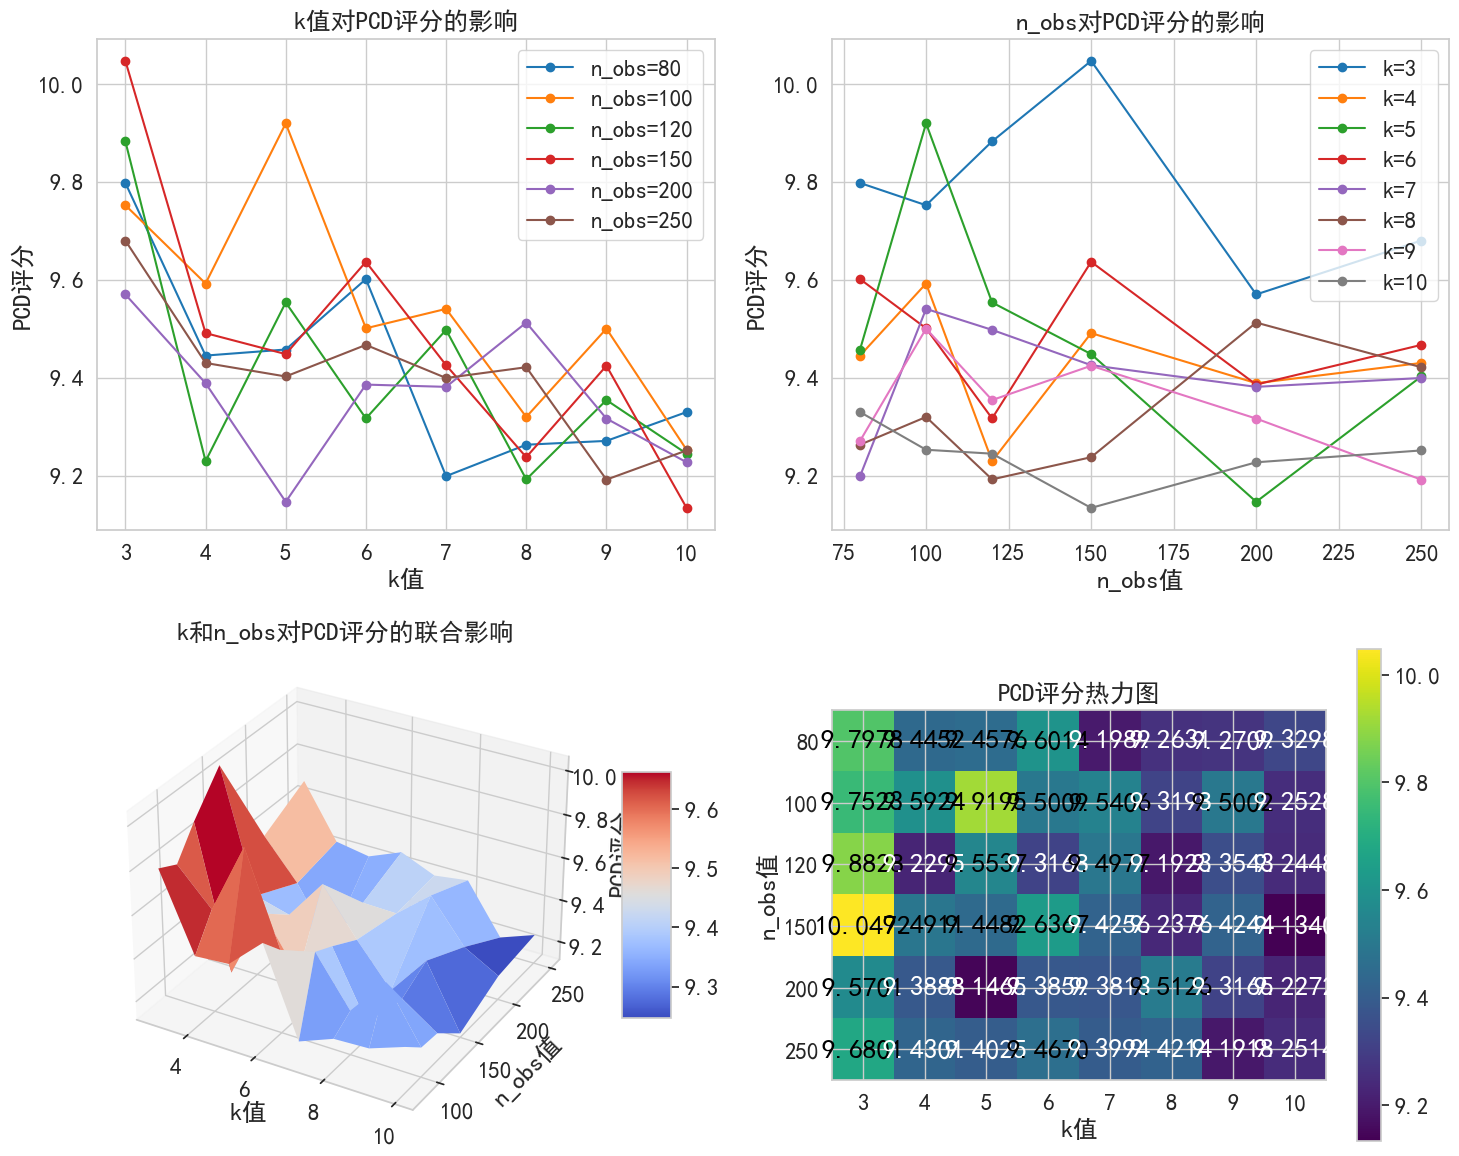

In [116]:

# 创建图形
plt.figure(figsize=(15, 12))

# 绘制k值对PCD的影响（n_obs作为不同曲线）
plt.subplot(2, 2, 1)
for n_obs in n_obs_list:
    subset = results_df[results_df['n_obs'] == n_obs]
    plt.plot(subset['k'], subset['PCD'], 'o-', label=f'n_obs={n_obs}')
    
plt.xlabel('k值')
plt.ylabel('PCD评分')
plt.title('k值对PCD评分的影响')
plt.legend()
plt.grid(True)

# 绘制n_obs对PCD的影响（k作为不同曲线）
plt.subplot(2, 2, 2)
for k in k_list:
    subset = results_df[results_df['k'] == k]
    plt.plot(subset['n_obs'], subset['PCD'], 'o-', label=f'k={k}')
    
plt.xlabel('n_obs值')
plt.ylabel('PCD评分')
plt.title('n_obs对PCD评分的影响')
plt.legend()
plt.grid(True)

# 绘制3D曲面图
ax = plt.subplot(2, 2, 3, projection='3d')
X = results_df['k'].astype(float)
Y = results_df['n_obs'].astype(float)
Z = results_df['PCD']

# 创建网格
X_grid, Y_grid = np.meshgrid(np.unique(X), np.unique(Y))
Z_grid = np.zeros_like(X_grid)

# 填充Z值
for i, x in enumerate(np.unique(X)):
    for j, y in enumerate(np.unique(Y)):
        mask = (X == x) & (Y == y)
        if np.sum(mask) > 0:
            Z_grid[j, i] = Z[mask].values[0]

# 绘制3D曲面
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# 添加颜色条
fig = plt.gcf()
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('k值')
ax.set_ylabel('n_obs值')
ax.set_zlabel('PCD评分')
ax.set_title('k和n_obs对PCD评分的联合影响')

# 绘制热力图
plt.subplot(2, 2, 4)
pivot_table = results_df.pivot(index='n_obs', columns='k', values='PCD')
im = plt.imshow(pivot_table, cmap='viridis')

# 添加颜色条
plt.colorbar(im)

# 设置坐标轴
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)
plt.xlabel('k值')
plt.ylabel('n_obs值')
plt.title('PCD评分热力图')

# 在热力图上添加数值
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = plt.text(j, i, f"{pivot_table.iloc[i, j]:.4f}",
                       ha="center", va="center", color="w" if pivot_table.iloc[i, j] < pivot_table.values.mean() else "black")

plt.tight_layout()
plt.savefig('knnmtg_hyperparameter_optimization.png', dpi=300)
plt.show()

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import itertools

# 参数网格
k_list = [3, 4, 5, 6, 7, 8, 9,10,11,12]  # k值列表

# 存储结果
results = []

# 遍历所有参数组合
for k in k_list:
    print(f"Running k={k}")
    try:
        real = df.drop(columns=['Repeat_Unit'])
        # 初始化模型
        generator = kNNMTD(n_obs=200, k=k, random_state=42, sigma_factor=0.25)
        
        # 生成合成数据
        synthetic = generator.fit(train=real, class_col='Tg')
        
        # 计算PCD评分（越低越好）
        pcd = PCD(real, synthetic)
        
        results.append({
            'k': k,
            'PCD': pcd
        })
        
    except Exception as e:
        print(f"Error for k={k}: {e}")
        results.append({
            'k': k,
            'PCD': np.nan
        })

# 转换为DataFrame
results_df = pd.DataFrame(results)

# 找出最佳参数组合（PCD值最低）
best_params = results_df.loc[results_df['PCD'].idxmin()]
print(f"\n最佳参数组合: k={best_params['k']}, PCD={best_params['PCD']:.4f}")


Running k=3
Running k=4
Running k=5
Running k=6
Running k=7
Running k=8
Running k=9
Running k=10
Running k=11
Running k=12

最佳参数组合: k=5.0, PCD=9.2320


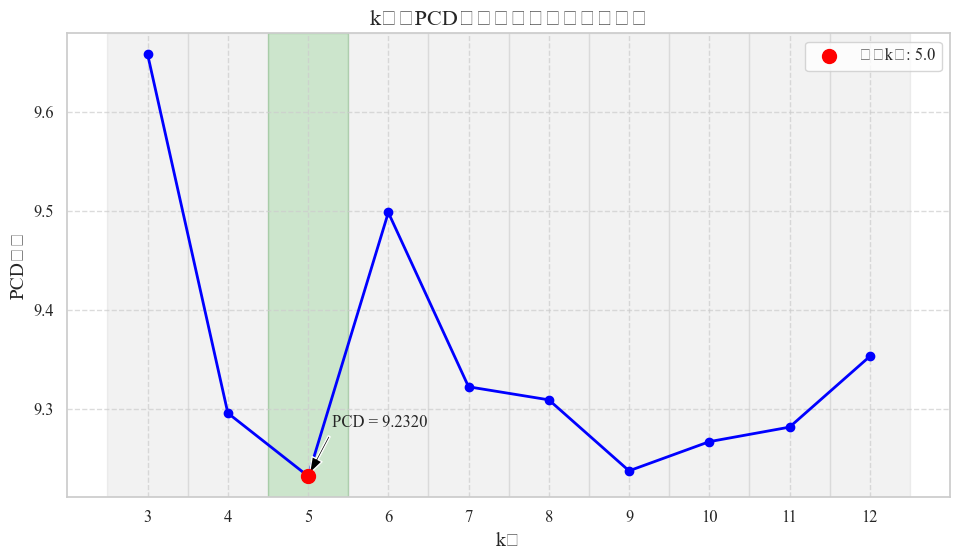

In [135]:
# 绘制k值学习曲线图
plt.figure(figsize=(10, 6))

# 绘制PCD评分随k值变化的曲线
plt.plot(results_df['k'], results_df['PCD'], 'o-', color='blue', linewidth=2)

# 标记最佳k值
plt.scatter([best_params['k']], [best_params['PCD']], color='red', s=100, zorder=5, label=f'最佳k值: {best_params["k"]}')

# 添加文本注释
plt.annotate(f'PCD = {best_params["PCD"]:.4f}', 
             xy=(best_params['k'], best_params['PCD']),
             xytext=(best_params['k']+0.3, best_params['PCD']+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12)

# 设置图表属性
plt.xlabel('k值', fontsize=14)
plt.ylabel('PCD评分', fontsize=14)
plt.title('k值对PCD评分的影响（学习曲线）', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_list, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# 添加背景色区分不同k值范围
for i, k in enumerate(k_list):
    if k == best_params['k']:
        plt.axvspan(k-0.5, k+0.5, color='green', alpha=0.2, zorder=0)
    else:
        plt.axvspan(k-0.5, k+0.5, color='gray', alpha=0.1, zorder=0)

plt.tight_layout()
plt.savefig('knnmtg_k_learning_curve.png', dpi=300)
plt.show()

In [239]:
synthetic['Tg'] = synthetic['Tg'].round(2)
combined_data = pd.concat([real, synthetic], ignore_index=True)
combined_data ['Tg'].describe()
# combined_data.to_csv('polymer_content_combined_data.csv')

count    240.000000
mean     245.106875
std        7.331345
min      228.910000
25%      241.112500
50%      246.320000
75%      249.405000
max      258.310000
Name: Tg, dtype: float64

In [279]:
X = synthetic.drop(columns=['Tg'])
# y = combined_data['Tg']
y = synthetic['Tg']
y = y.to_numpy()
y = y.reshape(-1, 1)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=66)
# y = combined_data['Tg']
# y = y.to_numpy()
# y = y.reshape(-1, 1)
# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y)
# X_train = synthetic.drop(columns=['Tg'])
# y_train = y_scaled[-200:]
# X_test = real.drop(columns=['Tg'])
# y_test = y_scaled[:-200]

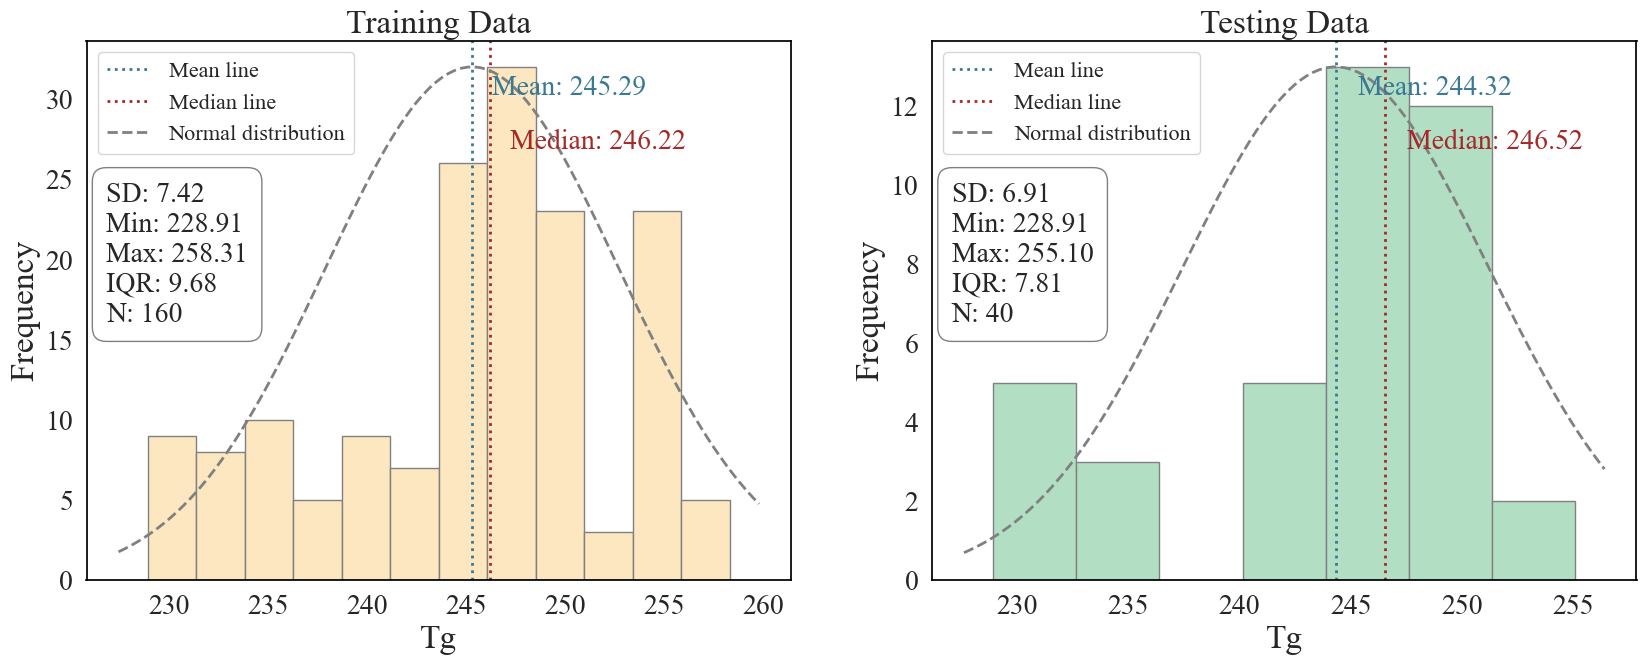

In [218]:
#测试集训练集数据分布
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# liver_data = synthetic['Tg']
# data = df['Tg']

liver_data = y_test.copy()
data = y_train.copy()

# 计算 liver_data 的统计信息
mean_liver = np.mean(liver_data)
median_liver = np.median(liver_data)
std_dev_liver = np.std(liver_data)
min_val_liver = np.min(liver_data)
max_val_liver = np.max(liver_data)
iqr_liver = np.percentile(liver_data, 75) - np.percentile(liver_data, 25)
n_liver = len(liver_data)

# 计算 data 的统计信息
mean_data = np.mean(data)
median_data = np.median(data)
std_dev_data = np.std(data)
min_val_data = np.min(data)
max_val_data = np.max(data)
iqr_data = np.percentile(data, 75) - np.percentile(data, 25)
n_data = len(data)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 子图 1：绘制 data 的数据
ax1 = axes[0]
counts_data, bins_data, _ = ax1.hist(data, color='#fce7c0', edgecolor='gray',bins=12)
# 添加统计信息
ax1.axvline(mean_data, color='#397995', linestyle='dotted', linewidth=2, label='Mean line')
ax1.axvline(median_data, color='#a62927', linestyle='dotted', linewidth=2, label='Median line')
# 添加标签
ax1.text(mean_data + 1, ax1.get_ylim()[1]*0.9, f'Mean: {mean_data:.2f}', color='#397995')
ax1.text(median_data + 1, ax1.get_ylim()[1]*0.8, f'Median: {median_data:.2f}', color='#a62927')
# 绘制正态分布曲线
xmin_data, xmax_data = ax1.get_xlim()
x_data = np.linspace(xmin_data, xmax_data, 100)
p_data = norm.pdf(x_data, mean_data, std_dev_data)
scale_factor_data = max(counts_data) / max(p_data)
ax1.plot(x_data, p_data * scale_factor_data, 'grey', linewidth=2, linestyle='--', label='Normal distribution')
# 创建额外统计信息字典
stats_info_data = {
    'SD': f'{std_dev_data:.2f}',
    'Min': f'{min_val_data:.2f}',
    'Max': f'{max_val_data:.2f}',
    'IQR': f'{iqr_data:.2f}',
    'N': f'{n_data}'
}
# 创建文本框
text_box_data = ax1.text(0.028, 0.48, '\n'.join([f'{key}: {value}' for key, value in stats_info_data.items()]),
                         transform=ax1.transAxes,
                         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
ax1.legend(loc=2,fontsize=16)
ax1.grid(False)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
ax1.set_title('Training Data', fontsize=24)
ax1.set_xlabel('Tg', fontsize=24)
ax1.set_ylabel('Frequency', fontsize=24)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
# 子图 2：绘制 liver_data 的数据
ax2 = axes[1]
counts_liver, bins_liver, _ = ax2.hist(liver_data, color='#b2dec4', edgecolor='gray',bins=7)
# 添加统计信息
ax2.axvline(mean_liver, color='#397995', linestyle='dotted', linewidth=2, label='Mean line')
ax2.axvline(median_liver, color='#a62927', linestyle='dotted', linewidth=2, label='Median line')
# 添加标签
ax2.text(mean_liver + 1, ax2.get_ylim()[1]*0.9, f'Mean: {mean_liver:.2f}', color='#397995')
ax2.text(median_liver + 1, ax2.get_ylim()[1]*0.8, f'Median: {median_liver:.2f}', color='#a62927')
# 绘制正态分布曲线
xmin_liver, xmax_liver = ax2.get_xlim()
x_liver = np.linspace(xmin_liver, xmax_liver, 100)
p_liver = norm.pdf(x_liver, mean_liver, std_dev_liver)
scale_factor_liver = max(counts_liver) / max(p_liver)
ax2.plot(x_liver, p_liver * scale_factor_liver, 'grey', linewidth=2, linestyle='--', label='Normal distribution')
# 创建额外统计信息字典
stats_info_liver = {
    'SD': f'{std_dev_liver:.2f}',
    'Min': f'{min_val_liver:.2f}',
    'Max': f'{max_val_liver:.2f}',
    'IQR': f'{iqr_liver:.2f}',
    'N': f'{n_liver}'
}
# 创建文本框
text_box_liver = ax2.text(0.028, 0.48, '\n'.join([f'{key}: {value}' for key, value in stats_info_liver.items()]),
                          transform=ax2.transAxes,
                          bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
ax2.legend(loc=2,fontsize=16)
ax2.grid(False)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
ax2.set_title('Testing Data', fontsize=24)
ax2.set_xlabel('Tg', fontsize=24)
ax2.set_ylabel('Frequency', fontsize=24)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
plt.savefig("histogram_tt1.svg", dpi=1200, format="svg", transparent=True)
plt.show()

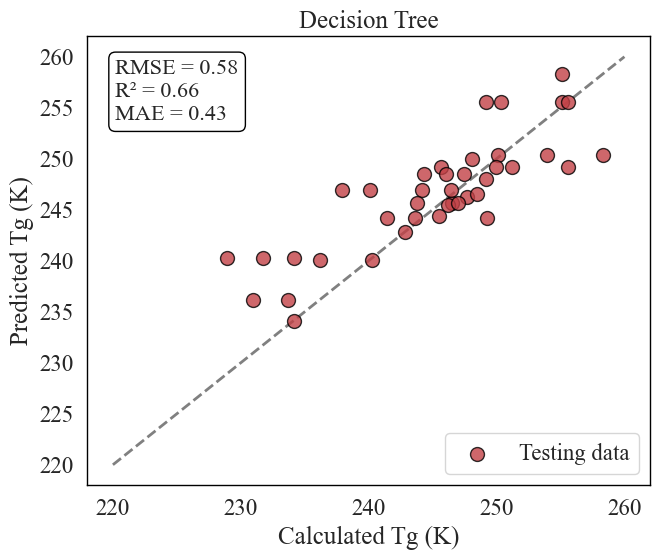

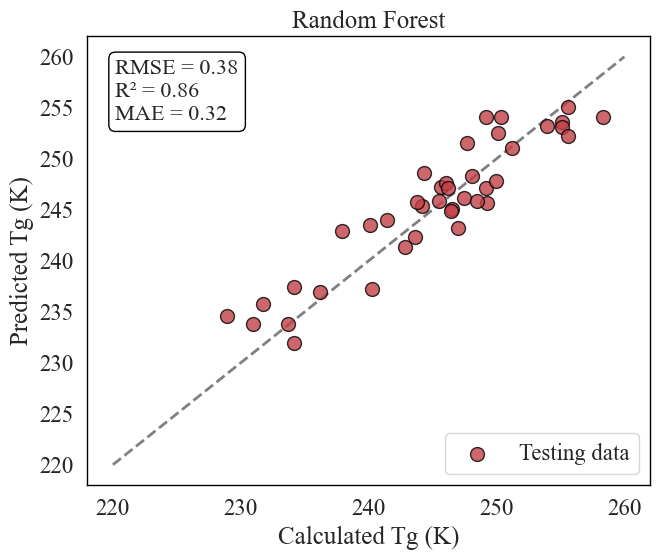

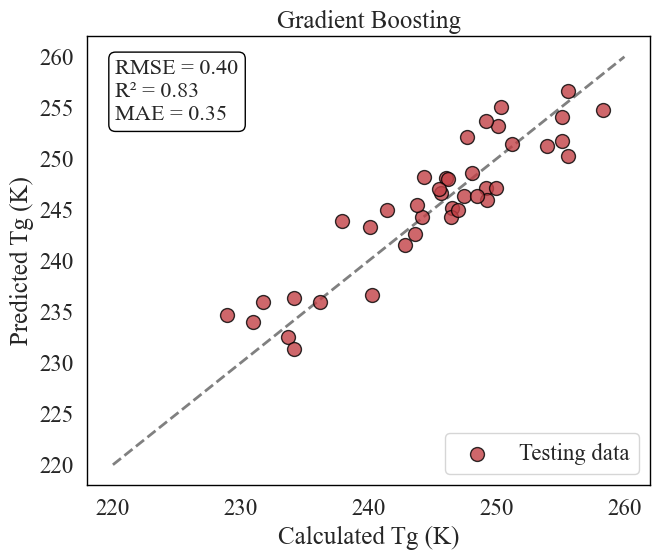

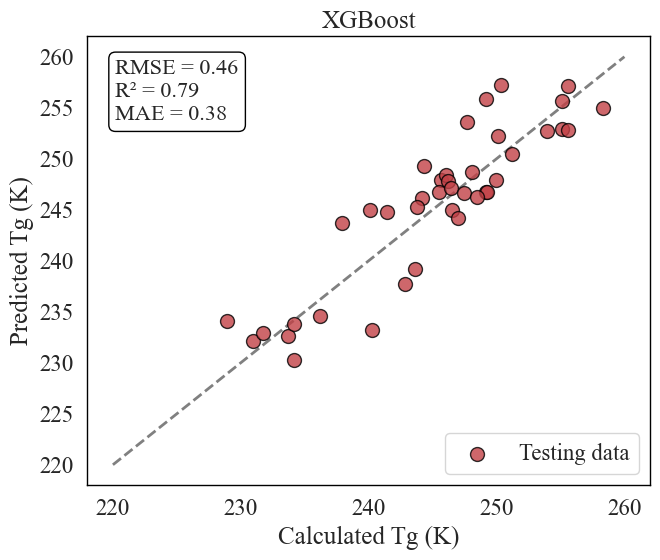

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 22
[LightGBM] [Info] Start training from score -0.001275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

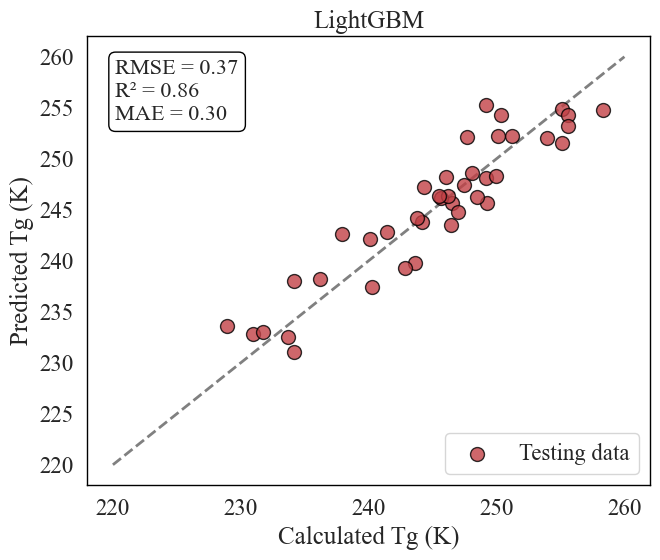

In [278]:
# ml model
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
}

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)
colors = sns.color_palette("BrBG_r") 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(7, 6))
  
    # 设置边框颜色为黑色
    ax = plt.gca()  # 获取当前坐标轴
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)  # 可选：设置边框宽度（默认约1.0）
    # 添加对角线
    plt.plot([220, 260], [220, 260], 'k--', linewidth=2, color='grey',zorder =0)
    # 绘制散点图
    # plt.scatter(y_test_unscaled, y_pred_unscaled, label='Training data', alpha=0.6, color='#608595', marker='o')
    plt.scatter(y_test_unscaled, y_pred_unscaled, label='Testing data', alpha=0.8, color='#C24146', marker='o',s=100,edgecolors='black')



    # 添加R²值文本
    plt.text(0.05, 0.95, f'RMSE = {rmse:.2f}\nR² = {r2:.2f}\nMAE = {mae:.2f}', 
            transform=plt.gca().transAxes,  # 使用当前轴的坐标系
            fontsize=16, verticalalignment='top', 
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    # 设置标签和标题
    plt.xlabel('Calculated Tg (K)')
    plt.ylabel('Predicted Tg (K)')
    plt.title(f'{name}')
    # plt.xlabel('Calculated diffusion coefficient (×$10^{-8}$ m²/s)')
    # plt.ylabel('Predicted diffusion coefficient (×$10^{-8}$ m²/s)')
    plt.legend(loc='lower right')

    # 显示网格线
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.grid(False)
    # 调整布局
    plt.tight_layout()

    # 保存或显示图表
    plt.savefig(f'{name}_generated vs original values.svg', format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
    # plt.savefig(f'{name}_generated vs original values_diff.svg', format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
    plt.show()




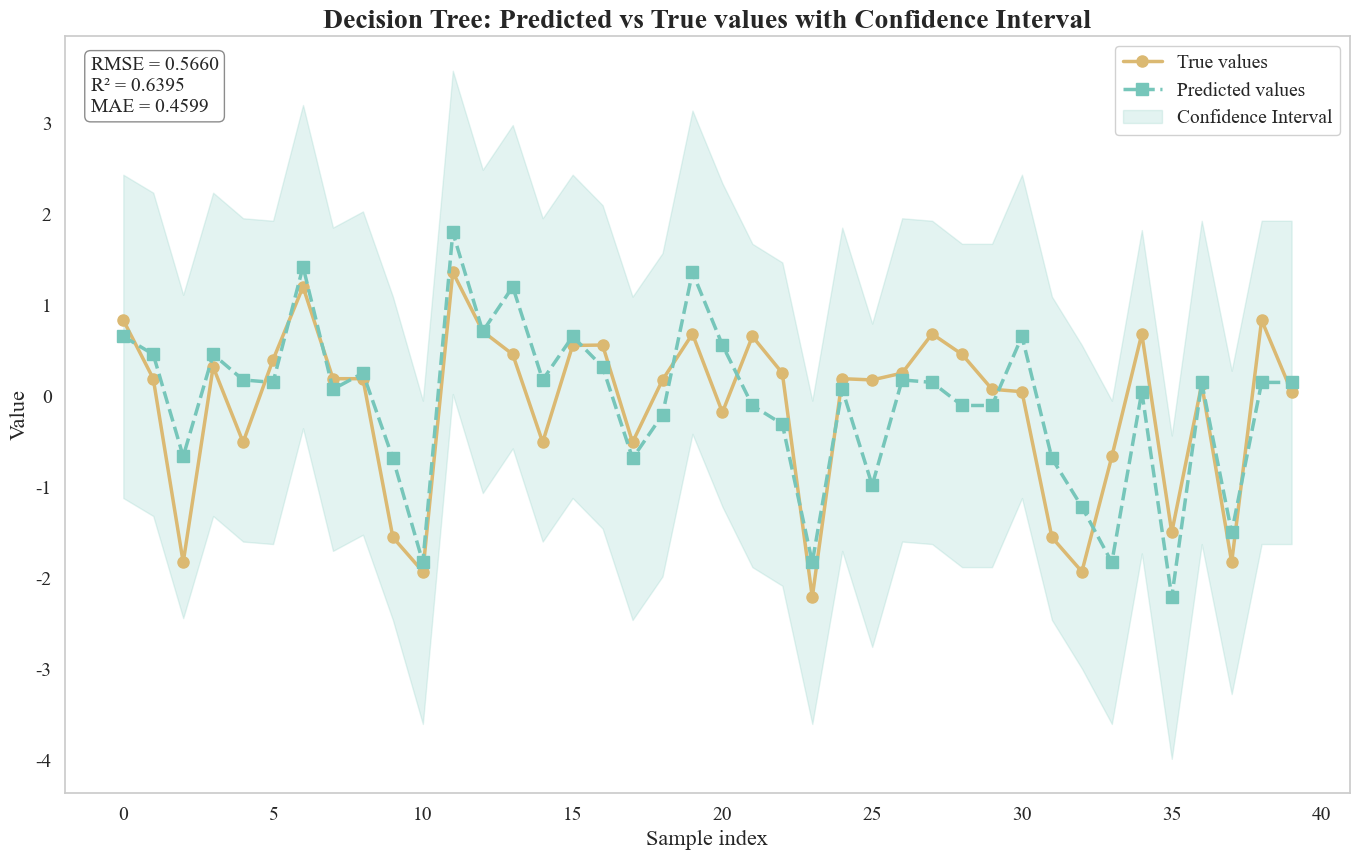

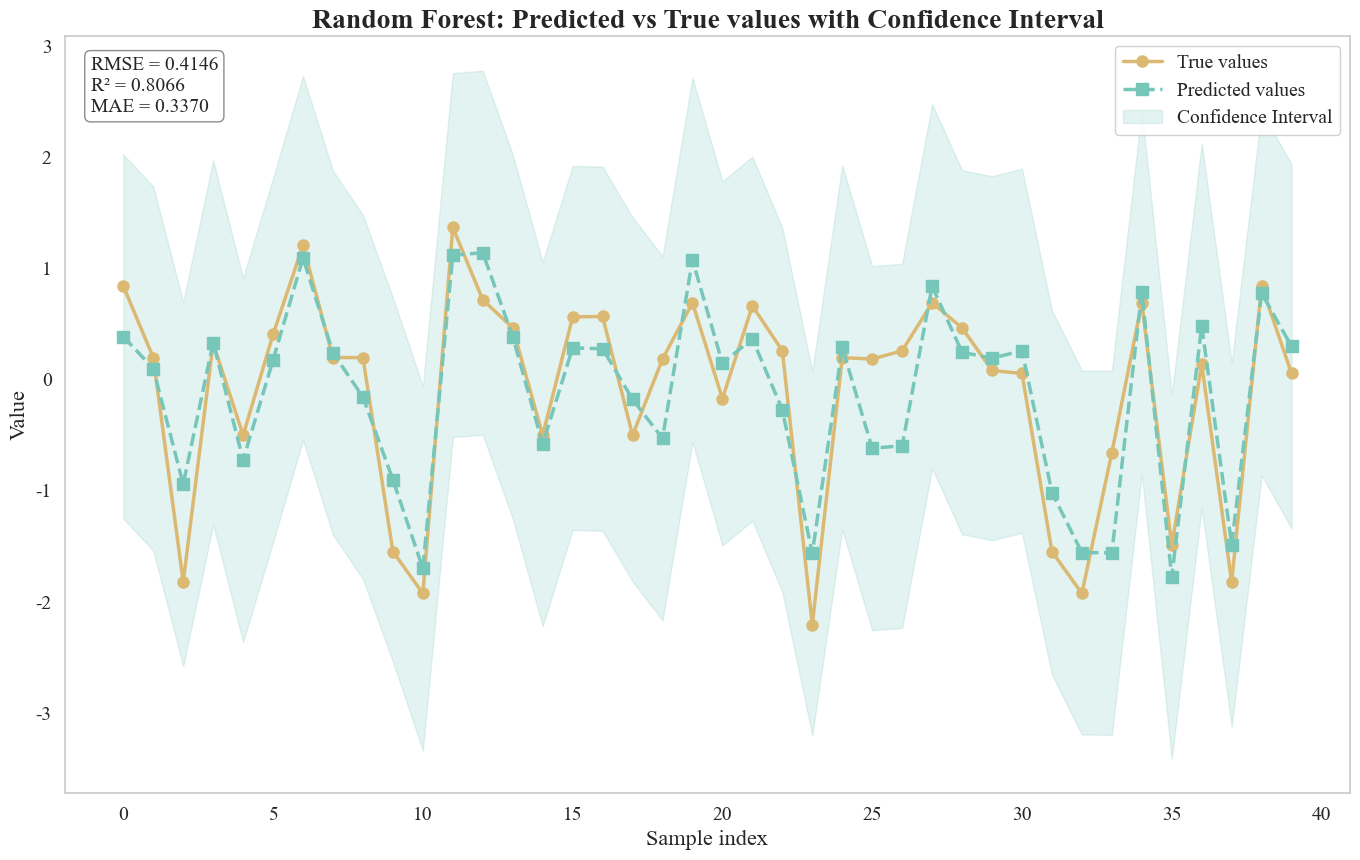

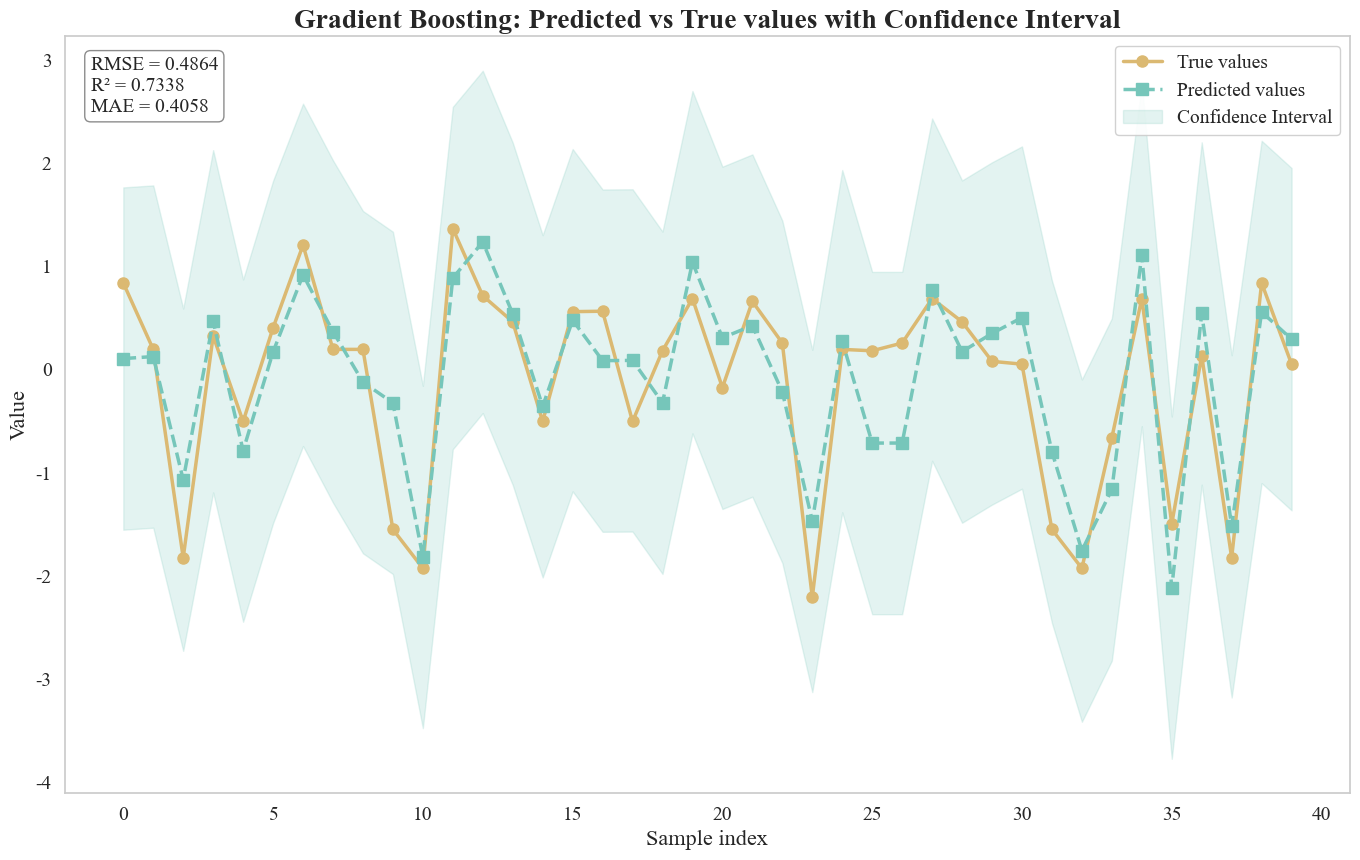

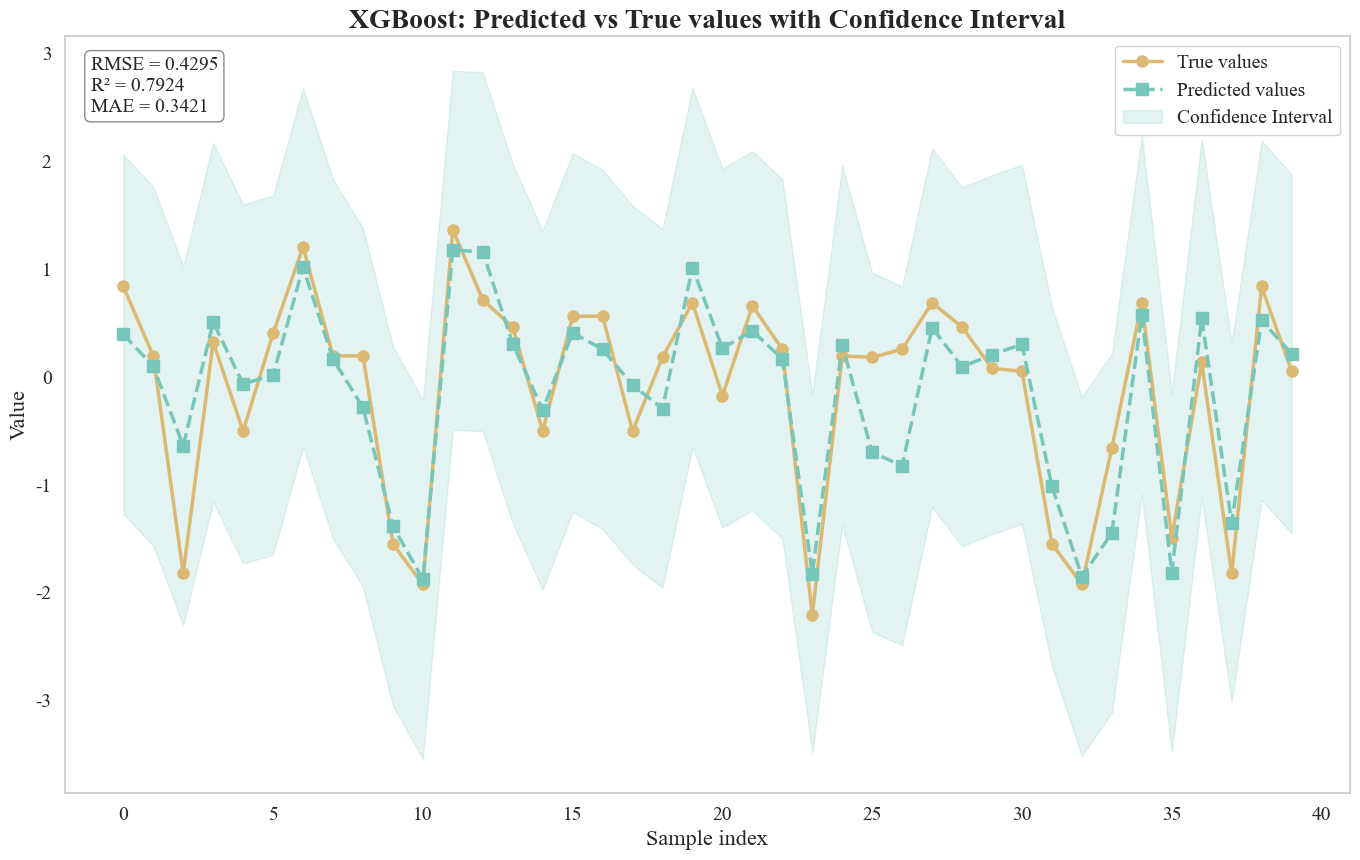

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 22
[LightGBM] [Info] Start training from score 0.026553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

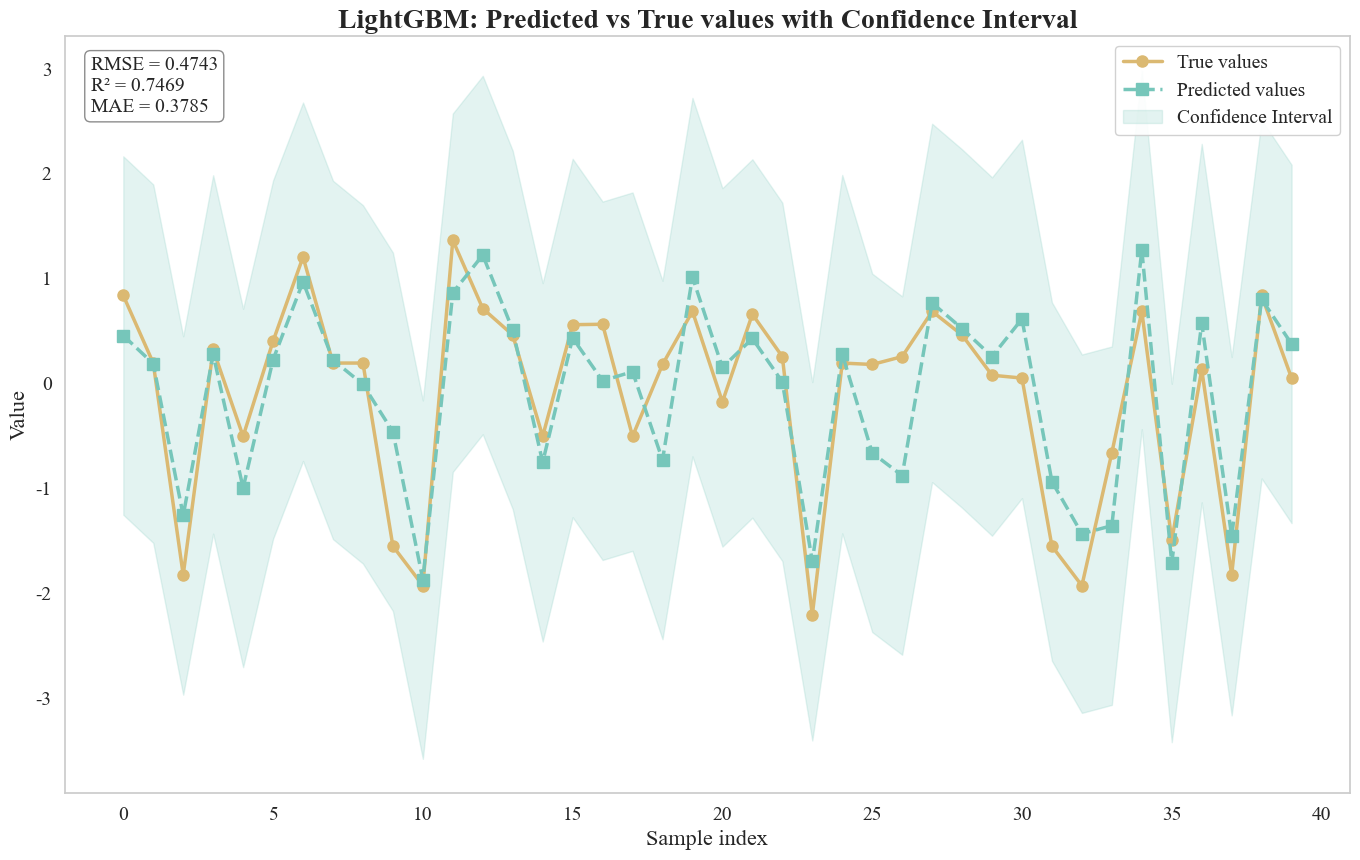

In [280]:
# ml model
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
}

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)
colors = sns.color_palette("BrBG_r") 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    index = range(len(y_pred))
    confidence_interval = 1.96 * np.std(y_pred) 

    plt.figure(figsize=(14, 9))
    plt.plot(index, y_test, 
             label='True values', 
             marker='o', 
             linestyle='-', 
             color=colors[4], 
             linewidth=2.5,
             markersize=8)
    plt.plot(index, y_pred, 
             label='Predicted values', 
             marker='s', 
             linestyle='--', 
             color=colors[1], 
             linewidth=2.5,
             markersize=8)
    plt.fill_between(index, 
                     y_pred - confidence_interval, 
                     y_pred + confidence_interval, 
                     color=colors[1], 
                     alpha=0.2, 
                     label='Confidence Interval')

    textstr = f'RMSE = {rmse:.4f}\nR² = {r2:.4f}\nMAE = {mae:.4f}'
    plt.text(0.02, 0.9, textstr, 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.9),
             fontsize=14)
    plt.grid(False)
    plt.title(f'{name}: Predicted vs True values with Confidence Interval', 
              fontsize=20, fontweight='bold')
    plt.xlabel('Sample index', fontsize=16)
    plt.ylabel('Value', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', fontsize=14, framealpha=0.9)
    plt.tight_layout()
    plt.savefig(f'{name}_Predicted vs True values with Confidence Interval.svg', format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
    plt.show()



In [281]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)

print("\n=== 随机森林模型参数 ===")
for param, value in rf_model.get_params().items():
    print(f"{param}: {value}")


=== 随机森林模型参数 ===
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


  实验 1/10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 22
[LightGBM] [Info] Start training from score 0.026553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

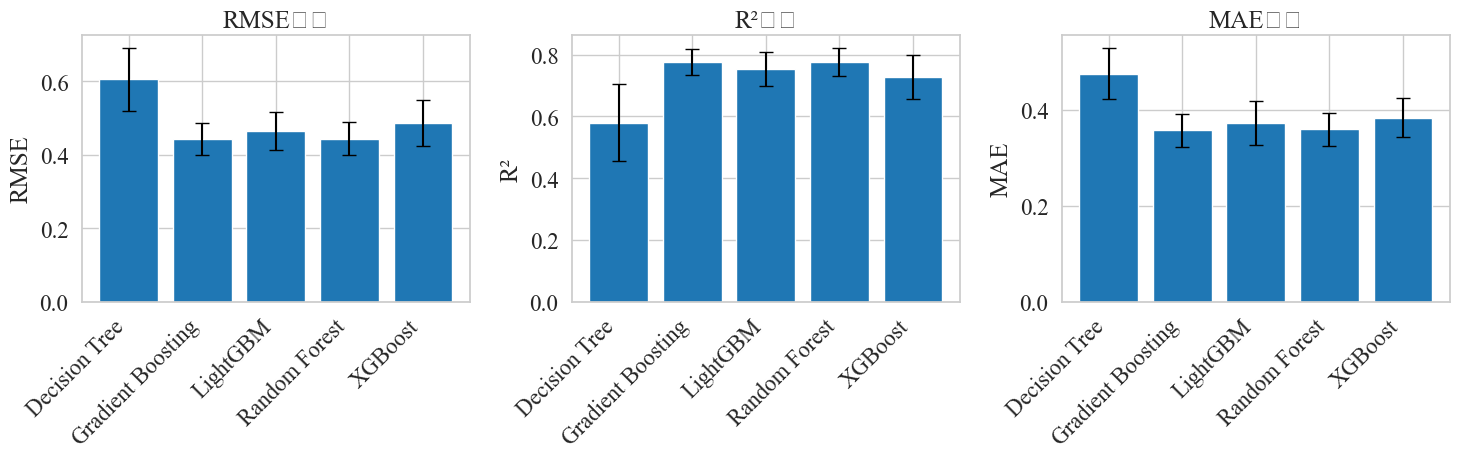

In [211]:
n_experiments = 10  # 重复实验次数
n_obs = 200
k = 5  # 固定k值

# 存储所有实验结果
all_results = []

# 定义要评估的模型
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
}

# 主实验循环
for exp_id in range(n_experiments):
    print(f"  实验 {exp_id+1}/{n_experiments}")    
    try:
        # 设置基于实验ID的随机种子
        random_seed = 42 + exp_id * 100
        
        real = df.drop(columns=['Repeat_Unit'])
        # 初始化模型，使用不同的随机种子
        generator = kNNMTD(n_obs=n_obs, k=k, random_state=random_seed, sigma_factor=0.25)
        
        # 生成合成数据
        synthetic = generator.fit(train=real, class_col='Tg')

        X = synthetic.drop(columns=['Tg'])
        y = synthetic['Tg']
        
        # 数据标准化
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
        X_scaled = X_scaler.fit_transform(X)
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).ravel()
        
        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_scaled, test_size=0.2, random_state=66
        )
        
        # 评估所有模型
        for name, model in models.items():
            # 训练模型
            model.fit(X_train, y_train)
            
            # 预测和评估
            y_pred = model.predict(X_test)
            
            # 计算性能指标
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            # 存储本次实验结果
            all_results.append({
                'experiment_id': exp_id,
                'random_state': random_seed,
                'model': name,
                'RMSE': rmse,
                'R2': r2,
                'MAE': mae
            })
            
    except Exception as e:
        print(f"  实验出错: {e}")
        # 存储错误信息
        for name in models.keys():
            all_results.append({
                'experiment_id': exp_id,
                'model': name,
                'RMSE': np.nan,
                'R2': np.nan,
                'MAE': np.nan
            })

# 转换为DataFrame
results_df = pd.DataFrame(all_results)

# 计算每个模型的平均性能和标准差
summary_df = results_df.groupby('model').agg({
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std'],
    'MAE': ['mean', 'std']
}).reset_index()

# 扁平化列名
summary_df.columns = ['_'.join(col).strip('_') for col in summary_df.columns.values]

# 打印性能比较
print("\n=== 模型性能比较 ===")
print(summary_df.sort_values('R2_mean'))

# 可视化模型性能比较
plt.figure(figsize=(15, 5))

# RMSE比较
plt.subplot(1, 3, 1)
plt.bar(summary_df['model'], summary_df['RMSE_mean'], 
        yerr=summary_df['RMSE_std'], capsize=5)
plt.title('RMSE比较')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')

# R2比较
plt.subplot(1, 3, 2)
plt.bar(summary_df['model'], summary_df['R2_mean'], 
        yerr=summary_df['R2_std'], capsize=5)
plt.title('R²比较')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')

# MAE比较
plt.subplot(1, 3, 3)
plt.bar(summary_df['model'], summary_df['MAE_mean'], 
        yerr=summary_df['MAE_std'], capsize=5)
plt.title('MAE比较')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
# plt.savefig('model_performance_comparison.png')
plt.show()

# 保存结果到CSV
# results_df.to_csv('model_performance_results.csv', index=False)
# summary_df.to_csv('model_performance_summary.csv', index=False)

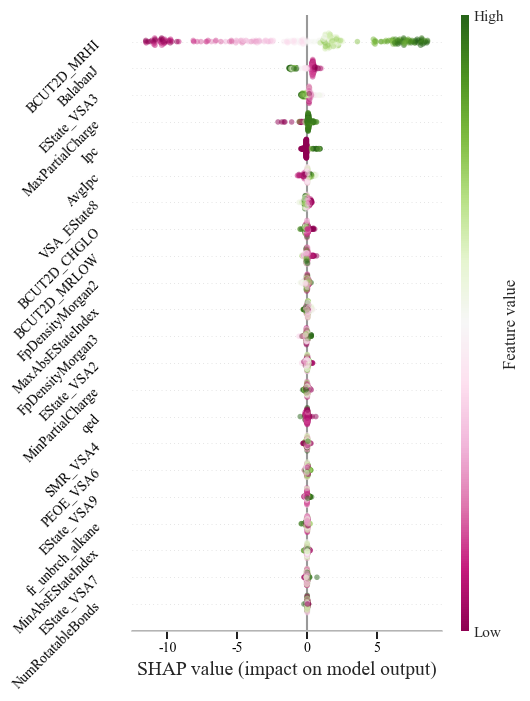

In [165]:
# shap
shap.initjs()
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})
features = combined_data.drop('Tg', axis=1) 
labels = combined_data['Tg']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
combined_data_scaled = pd.concat([features_scaled_df, labels.reset_index(drop=True)], axis=1)

SX = combined_data_scaled.iloc[:,:-1]
SY = combined_data_scaled.iloc[:,-1]

start_time = time.time()
model = RandomForestRegressor()
# model = XGBRegressor()
model.fit(SX, SY)
explainer = shap.Explainer(model)
shap_values = explainer(SX)
end_time = time.time()
execution_time = end_time - start_time
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values, max_display=30, plot_size=(5, 8), color=plt.get_cmap("PiYG"), alpha=0.5, axis_color='#000000', show=False)
ax.grid(False)
ax.axhline(y=-1, color='black', linewidth=2, xmin=-5, xmax=5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
ax.set_xlabel('SHAP value (impact on model output)', fontsize=14)
cbar = plt.gcf().axes[0]
cbar.tick_params(labelsize=10, pad=1) 
plt.savefig("shap_plots.svg", format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
plt.show()

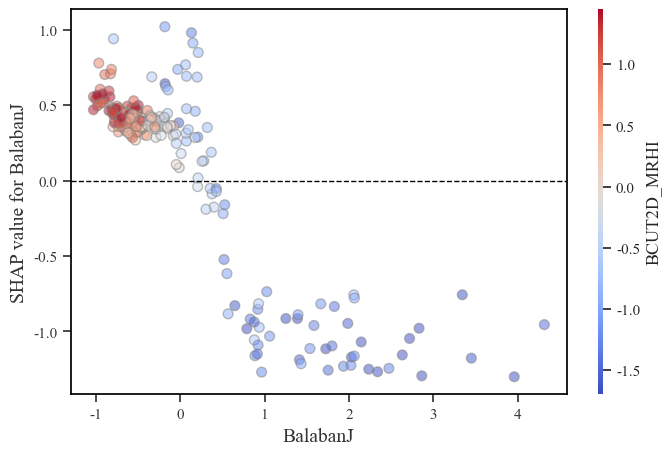

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 5))
shap.dependence_plot('BalabanJ', shap_values.values, SX, interaction_index='BCUT2D_MRHI', cmap='coolwarm', show=False, ax=ax)
scatter = ax.collections[0]
offsets = scatter.get_offsets()
array = scatter.get_array()
scatter.remove()
points = ax.scatter(offsets[:, 0], offsets[:, 1], c=array, cmap='coolwarm', alpha=0.5, s=50, edgecolor='grey')
ax.axhline(y=0, color='#000000', linewidth=1, ls='--')
ax.grid(False)

for spine in ax.spines.values():
    spine.set_edgecolor('black')

ax.set_ylabel('SHAP value for BalabanJ', fontsize=14)
ax.set_xlabel('BalabanJ', fontsize=14)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.savefig("shap_BB.svg", format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
plt.show()


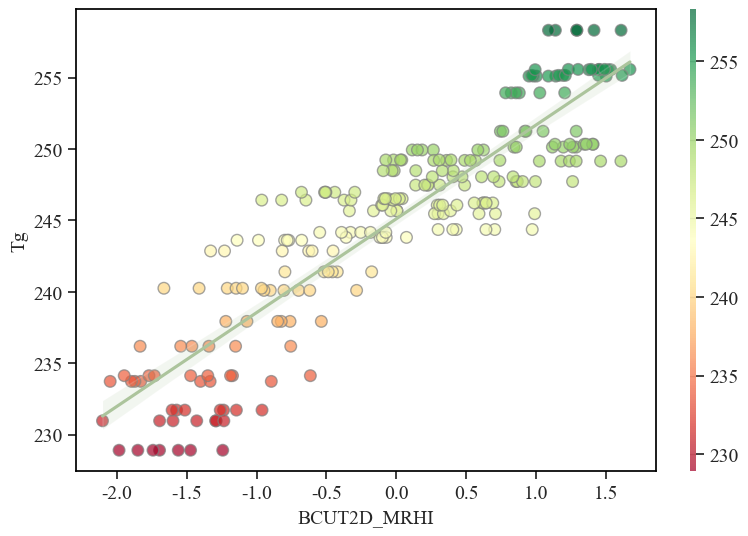

In [185]:
BalabanJ_df = combined_data_scaled['BCUT2D_MRHI']
# BalabanJ_df = np.log(BalabanJ_df+1)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 6))
sc=plt.scatter(BalabanJ_df, combined_data_scaled['Tg'], alpha=0.7, c=combined_data_scaled['Tg'],edgecolor='grey', cmap='RdYlGn',  s=70, marker='o')
sns.regplot(x=BalabanJ_df, y=combined_data_scaled['Tg'], scatter=False, color='#acc49c')
plt.xlabel('BCUT2D_MRHI', fontsize=14)
plt.ylabel('Tg', fontsize=14)

plt.grid(False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('#000000')
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.34) 
cbar = plt.colorbar(sc, cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)
for spine in cbar.ax.spines.values():
    spine.set_visible(False)
plt.savefig("BCUT2D_MRHI.svg", format="svg", dpi=1200, bbox_inches="tight",  transparent=True)
plt.show()

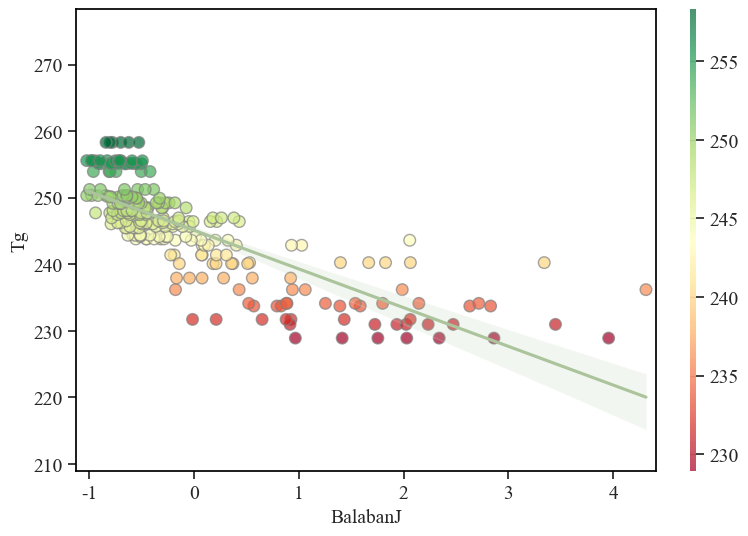

In [182]:
BalabanJ_df = combined_data_scaled['BalabanJ']
# BalabanJ_df = np.log(BalabanJ_df + 1)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 6))

# 绘制散点图和回归曲线
sc = plt.scatter(
    BalabanJ_df, combined_data_scaled['Tg'], 
    alpha=0.7, c=combined_data_scaled['Tg'], edgecolor='grey', 
    cmap='RdYlGn', s=70, marker='o'
)
sns.regplot(x=BalabanJ_df, y=combined_data_scaled['Tg'], scatter=False, color='#acc49c')

# 或方法二：动态范围（基于数据自动扩展）
x_min, x_max = BalabanJ_df.min(), BalabanJ_df.max()
y_min, y_max = combined_data_scaled['Tg'].min(), combined_data_scaled['Tg'].max()
plt.xlim(left=x_min - 0.1, right=x_max + 0.1)
plt.ylim(bottom=y_min - 20, top=y_max + 20)

plt.xlabel('BalabanJ', fontsize=14)
plt.ylabel('Tg', fontsize=14)
plt.grid(False)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('#000000')
ax.tick_params(axis='both', which='major', bottom=True, left=True, labelsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.34) 
cbar = plt.colorbar(sc, cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

plt.savefig("BCUT2D_MRHI.svg", format="svg", dpi=1200, bbox_inches="tight", transparent=True)
plt.show()